In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold
import optuna
from optuna.samplers import TPESampler

In [2]:
os.chdir("../input/tabular-playground-series-jan-2021")

# 1. Data loading

In [32]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
print("Missing data in the train data:　%s" %(train.isnull().sum().any()))
print("Missing data in the train data:　%s" %(test.isnull().sum().any()))

Missing data in the train data:　False
Missing data in the train data:　False


There is no missing data in both train data and test data.

# 2. Data visualization

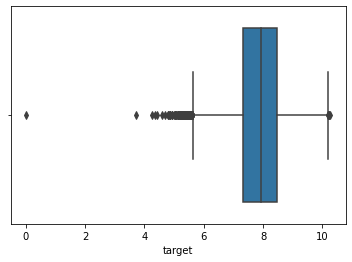

In [5]:
sns.boxplot(train.target)

There is an possible outlier with a value of 0.

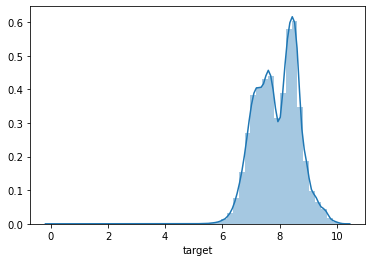

In [6]:
sns.distplot(train.target)

This is an bimodal distribution

In [7]:
"""
from sklearn.mixture import GaussianMixture

gmm= GaussianMixture(n_components=2, random_state=42)
gmm.fit(train.target.values.reshape(-1,1))
train["target_classes"]=gmm.predict(train.target.values.reshape(-1,1))
train
"""

'\nfrom sklearn.mixture import GaussianMixture\n\ngmm= GaussianMixture(n_components=2, random_state=42)\ngmm.fit(train.target.values.reshape(-1,1))\ntrain["target_classes"]=gmm.predict(train.target.values.reshape(-1,1))\ntrain\n'

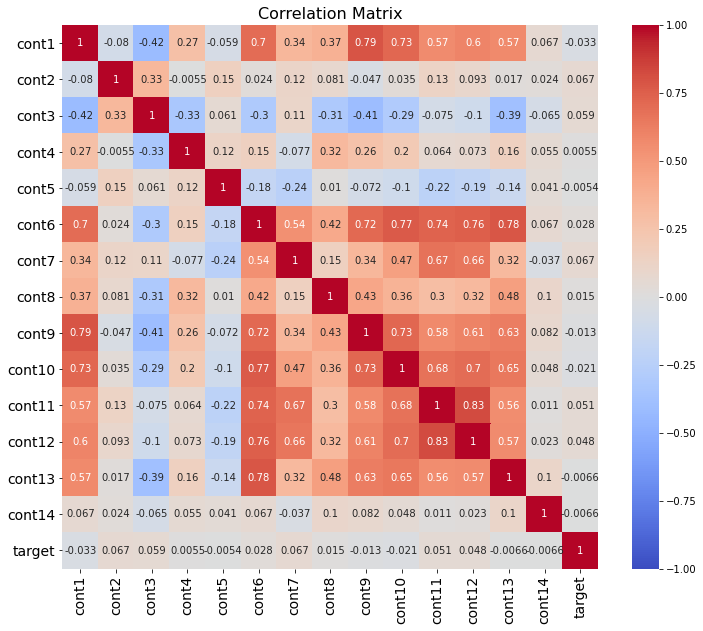

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train[train.columns[train.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

In [9]:
def distplot(df):
        
    plt.figure(figsize=(20,20))
    
    for i in range(1,15):
        plt.subplot(4,4,i)
        sns.distplot(df["cont"+str(i)],kde=False)
        plt.ylim(0,80000)
        #plt.tick_params(labelbottom=False)
        #plt.tick_params(labelleft=False)

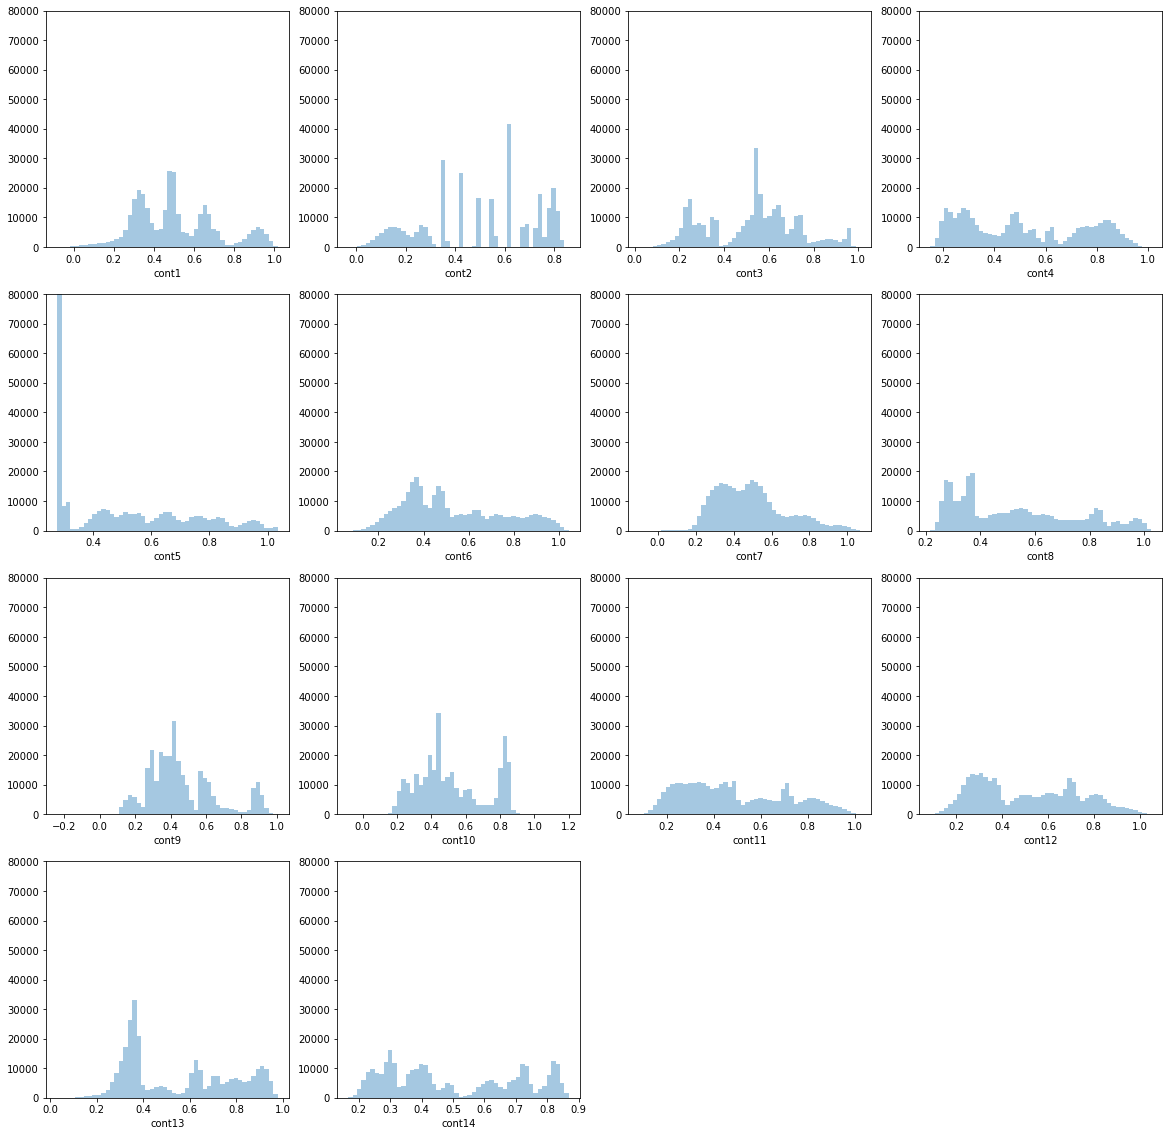

In [10]:
distplot(train[train.columns.drop("target")])

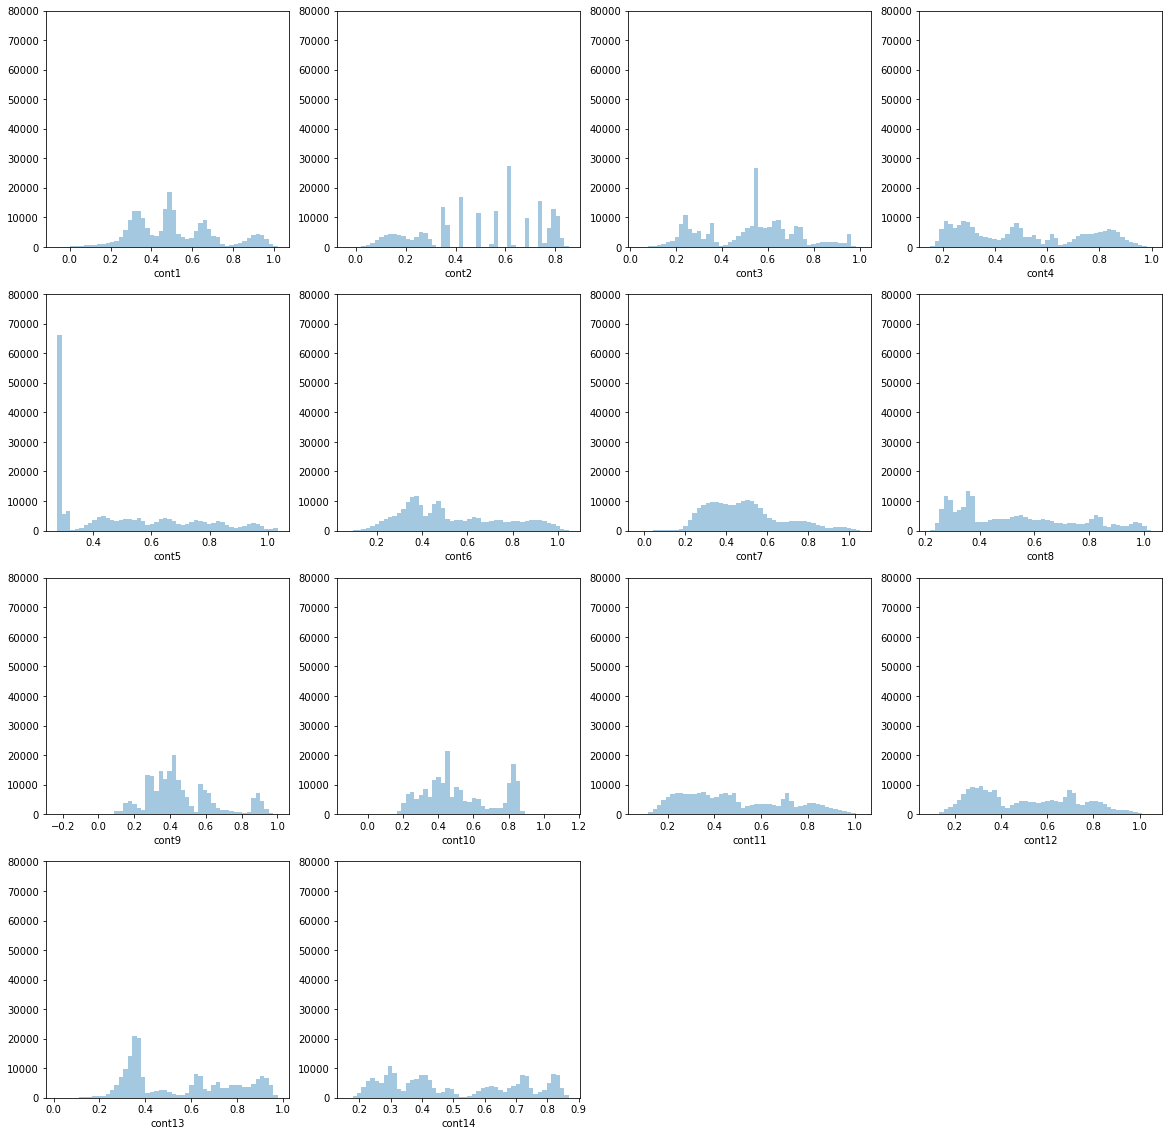

In [11]:
distplot(test)

# **3. Data Processing**

remove outlier

In [12]:
outlier=[]
for i in range(len(train)):
    if train.target[i]==0:
        outlier.append(i)
print(outlier)

[170514]


In [13]:
train=train.drop(train.index[(outlier)])
train

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,0.315397,0.247682,0.486542,0.288750,7.385215
299996,499996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,0.360251,0.360755,0.292535,0.619984,7.242617
299997,499997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,0.491735,0.516629,0.173521,0.714552,9.592487
299998,499998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,0.984647,1.001110,0.063956,0.377693,8.207951


Feature engineering

In [14]:
X=train[train.columns.drop(["id","target"])]
y=train["target"]

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2,include_bias=False) #interaction_only=Trueにしたらやや悪化した
X_poly=poly.fit_transform(X)
X_poly=pd.DataFrame(X_poly)
X_poly

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,...,0.718493,0.675578,0.684900,0.238043,0.799018,0.810044,0.281538,0.761661,0.264722,0.268375
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,...,0.190303,0.188182,0.160055,0.159851,0.191331,0.162734,0.162526,0.160921,0.160715,0.136693
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,...,0.466823,0.557965,0.726933,0.249502,0.384265,0.500632,0.171830,0.598374,0.205377,0.267572
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,...,0.447013,0.475212,0.531054,0.162362,0.629638,0.703626,0.215123,0.748013,0.228693,0.255567
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,...,0.849245,0.777485,0.808096,0.376258,0.885674,0.920545,0.428615,0.842760,0.392397,0.407847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,...,0.271400,0.213131,0.418672,0.248471,0.078118,0.153454,0.091071,0.120508,0.071518,0.140489
299995,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,...,0.163763,0.163993,0.132981,0.281833,0.129962,0.105386,0.223350,0.105534,0.223663,0.181367
299996,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,...,0.259107,0.272225,0.091433,0.376515,0.254044,0.085326,0.351370,0.089646,0.369158,0.123990
299997,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,...,0.638319,0.648991,0.041461,0.244848,0.985740,0.062974,0.371894,0.064027,0.378112,0.024156


In [33]:
test1=test[test.columns.drop("id")]
poly=PolynomialFeatures(degree=2,include_bias=False)
test_poly=poly.fit_transform(test1)
test_poly=pd.DataFrame(test_poly)
test_poly

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.353600,0.738780,0.600939,0.293377,0.285691,0.458006,0.620704,0.422249,0.369203,0.435727,...,0.239885,0.304632,0.124994,0.158829,0.384901,0.157930,0.200680,0.200556,0.254845,0.104566
1,0.907222,0.189756,0.215531,0.869915,0.301333,0.528958,0.390351,0.521112,0.794779,0.798580,...,0.356546,0.358592,0.732269,0.409673,0.200484,0.409401,0.229043,0.411751,0.230357,0.470405
2,0.179287,0.355353,0.623972,0.437812,0.282476,0.320826,0.386789,0.776422,0.222268,0.229102,...,0.048550,0.051010,0.074954,0.189683,0.047183,0.069330,0.175451,0.072843,0.184342,0.270872
3,0.359385,0.181049,0.551368,0.206386,0.280763,0.482076,0.506677,0.362793,0.379737,0.345686,...,0.153926,0.179233,0.103370,0.206778,0.230869,0.133150,0.266349,0.155041,0.310140,0.178868
4,0.335791,0.682607,0.676481,0.219465,0.282861,0.581721,0.748639,0.350158,0.448915,0.506878,...,0.414485,0.408491,0.400733,0.126352,0.658998,0.646483,0.203838,0.637134,0.200890,0.197075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.353856,0.677578,0.550852,0.869612,0.957635,0.255054,0.289138,0.635979,0.271399,0.282455,...,0.061340,0.061882,0.105429,0.076963,0.047579,0.081061,0.059174,0.081777,0.059697,0.101706
199996,0.243209,0.135627,0.218393,0.792798,0.547639,0.433520,0.549540,0.650107,0.453787,0.459689,...,0.207055,0.234982,0.146334,0.181920,0.230246,0.143385,0.178254,0.162725,0.202296,0.125980
199997,0.506973,0.683893,0.533434,0.192957,0.314381,0.358604,0.554455,0.267105,0.396101,0.445390,...,0.170431,0.177256,0.169798,0.164556,0.152289,0.145882,0.141378,0.151723,0.147039,0.140853
199998,0.347870,0.553112,0.495284,0.861500,0.816914,0.298478,0.275964,0.265841,0.334250,0.252635,...,0.053960,0.072057,0.085080,0.098150,0.060921,0.071931,0.082980,0.096055,0.110811,0.130837


# 4. Modeling

In [17]:
train_x, val_x, train_y, val_y=train_test_split(X_poly,y,random_state=42, test_size=0.2,shuffle=True)

In [18]:
#LGBMRegressor + optuna
sampler=TPESampler(seed=42)

def create_model_lgbm(trial):
    num_leaves=trial.suggest_int("num_leaves",2,31)
    n_estimators=trial.suggest_int("n_estimators",50,300)
    max_depth=trial.suggest_int("max_depth",3,8)
    min_child_samples=trial.suggest_int("min_child_samples",100,1200)
    learning_rate=trial.suggest_uniform("learning_rate",0.0001,0.99)
    min_data_in_leaf=trial.suggest_int('min_data_in_leaf',5,90)
    feature_fraction=trial.suggest_uniform('feature_fraction',0.0001,1.0)
    
    model=lgbm.LGBMRegressor(
    num_leaves=num_leaves,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    min_data_in_leaf=min_data_in_leaf,
    learning_rate=learning_rate,
    feature_fraction=feature_fraction,
    random_state=42)
    
    return model


#目的関数
def objective_lgbm(trial):
    model=create_model_lgbm(trial)
    model.fit(train_x,train_y)
    preds=model.predict(val_x)
    score=mean_squared_error(val_y,preds, squared=False)
    return score


study=optuna.create_study(direction="minimize", sampler=sampler)
optuna.logging.disable_default_handler()#don't show log
study.optimize(objective_lgbm, n_trials=100)


#最適解
print(study.best_params)
print(study.best_value)
#print(study.best_trial)

[I 2021-01-03 08:03:01,932] A new study created in memory with name: no-name-d1db3da1-37ce-4fd5-9be1-d34473481e8a


{'num_leaves': 26, 'n_estimators': 273, 'max_depth': 6, 'min_child_samples': 738, 'learning_rate': 0.1270857106337994, 'min_data_in_leaf': 87, 'feature_fraction': 0.33888927402101837}
0.6984199605048553


In [ ]:
params=study.best_params
#{'num_leaves': 26, 'n_estimators': 273, 'max_depth': 6, 'min_child_samples': 738, 'learning_rate': 0.1270857106337994, 'min_data_in_leaf': 87, 'feature_fraction': 0.33888927402101837}

lightGBM regressor + StratifiedKFold

In [25]:
tmp=X_poly.copy()
import random
fold_list = [1,2,3,4,5]
folds = []
for i in range(int((tmp.shape[0])/5)):
    random.shuffle(fold_list)
    folds.extend(fold_list)
folds+=[1,2,3,4]
tmp['fold'] = folds
tmp.head(7)

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,fold
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,...,0.675578,0.684900,0.238043,0.799018,0.810044,0.281538,0.761661,0.264722,0.268375,1
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,...,0.188182,0.160055,0.159851,0.191331,0.162734,0.162526,0.160921,0.160715,0.136693,5
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,...,0.557965,0.726933,0.249502,0.384265,0.500632,0.171830,0.598374,0.205377,0.267572,2
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,...,0.475212,0.531054,0.162362,0.629638,0.703626,0.215123,0.748013,0.228693,0.255567,3
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,...,0.777485,0.808096,0.376258,0.885674,0.920545,0.428615,0.842760,0.392397,0.407847,4
5,0.352623,0.258867,0.327373,0.802627,0.284219,0.296886,0.209743,0.273710,0.308018,0.235851,...,0.059294,0.079985,0.069135,0.070082,0.094537,0.081713,0.085261,0.073694,0.099410,4
6,0.259096,0.803934,0.580900,0.322884,0.984705,0.378247,0.432821,0.562059,0.290965,0.316543,...,0.103502,0.145183,0.077331,0.071671,0.100533,0.053549,0.149969,0.079880,0.112049,1


In [26]:
predictions = np.zeros(len(test_poly))
for fold in range(1,6):
    train_index_list = tmp[tmp['fold'] != fold].index
    test_index_list = tmp[tmp['fold'] == fold].index
                          
    X_train = X_poly.iloc[train_index_list]
    y_train = y.iloc[train_index_list]
    X_val = X_poly.iloc[test_index_list]
    y_val = y.iloc[test_index_list]

    model=lgbm.LGBMRegressor(**params)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train,eval_metric='rmse', eval_set=eval_set, verbose=False)#,early_stopping_rounds=5,
    predictions += model.predict(test_poly)
predictions = predictions/5

In [34]:
test["target"]=predictions

# 5. Submission

In [35]:
sample_submission=pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0.5
1,2,0.5
2,6,0.5
3,7,0.5
4,10,0.5


In [39]:
sample_submission=pd.merge(sample_submission["id"],test[["id","target"]], on="id")
sample_submission.head()

,id,target
0,0,7.961583
1,2,7.865092
2,6,7.928360
3,7,8.208849
4,10,8.237389


In [40]:
sample_submission.to_csv("/kaggle/working/submission4.csv", index=False)